In [1]:

import operator
import re
from copy import deepcopy

import networkx as nx
import numpy as np
import pandas as pd
import shap
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import _tree
from tqdm import tqdm

In [2]:
def tree_to_networkx(tree, feature_names=None, node=0, graph=None, pos=None, level=0, width=1., vert_gap=0.2, xcenter=0.5):
	if graph is None:
		graph = nx.DiGraph()
	
	if pos is None:
		pos = {node: (xcenter, level * -vert_gap)}
	else:
		pos[node] = (xcenter, level * -vert_gap)
	
	if tree.feature[node] != _tree.TREE_UNDEFINED:
		name = feature_names[tree.feature[node]]
		threshold = tree.threshold[node]
		condition = (name, np.round(threshold, 3))
		graph.add_node(node, label=condition)
		
		left_child = tree.children_left[node]
		right_child = tree.children_right[node]
		
		if left_child != right_child:  # If not a leaf node
			parent_rate = tree.value[node][0, 1] + tree.value[node][0, 0]
			graph, pos = tree_to_networkx(
					tree, feature_names, left_child, graph=graph, pos=pos,
					level=level - 1, width=width / 2., vert_gap=vert_gap, xcenter=xcenter - width / 2.
					)
			graph, pos = tree_to_networkx(
					tree, feature_names, right_child, graph=graph, pos=pos,
					level=level - 1, width=width / 2., vert_gap=vert_gap, xcenter=xcenter + width / 2.
					)
			graph.add_edge(node, left_child, label=('<', np.round(tree.value[node][0, 1] / parent_rate, 2)))
			graph.add_edge(node, right_child, label=('>=', np.round(tree.value[node][0, 0] / parent_rate, 2)))
	
	else:
		# Leaf node
		graph.add_node(node)
	
	return graph, pos

In [3]:
def generate_paths(graph, min_length=2, max_length=None):
	if max_length is None:
		max_length = len(graph)
	
	all_paths = []
	for root in graph.nodes:
		for leaf in graph.nodes:
			for path in nx.all_simple_paths(graph, root, leaf):
				
				if len(path) <= 1:
					continue
				
				all_paths.append(path)
	
	return all_paths


def return_paths(graph, paths, node_label_attr='label', edge_label_attr='label'):
	paths_aggregated = []
	for path in paths:
		node_names = [graph.nodes[node].get(node_label_attr, 'unknown') for node in path][: -1]
		edge_names = []
		for i in range(len(path) - 1):
			edge_data = graph.get_edge_data(path[i], path[i + 1])
			if edge_data and edge_label_attr in edge_data:
				edge_label = edge_data[edge_label_attr]
				edge_names.append(edge_label)
		
		result = []
		for node, edge in zip(node_names, edge_names):
			result.append(((node[0], edge[0], node[1]), edge[1]))
		
		paths_aggregated.append(result)
	
	return paths_aggregated

In [4]:
x_data, y_data = make_classification(n_samples=8096, n_features=16, n_informative=8)
x_data = np.abs(x_data) + 1e-3

x_data = pd.DataFrame(x_data, columns=[str(value) for value in list(range(1, 17))])

In [5]:
x_data

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.646667,2.068667,0.622467,0.894002,2.396024,1.443134,1.502990,4.728787,0.334799,2.462004,2.415637,3.000094,1.570454,1.040674,0.160872,1.219115
1,0.727514,0.431885,0.693477,1.957176,0.029952,1.676088,0.292154,1.970605,0.339391,1.921717,0.012174,2.585712,1.079710,1.889266,0.696290,0.778550
2,1.087297,0.580186,0.367525,0.177060,1.250418,1.375619,1.450481,4.951394,0.501132,0.937527,0.675435,0.858176,0.808817,1.228207,0.931406,0.333078
3,0.984535,0.443221,0.107519,0.176642,2.800435,2.087983,0.447295,1.281822,0.178139,2.348685,0.817207,6.448022,2.088012,0.608617,0.292220,3.688519
4,0.860216,1.140340,1.000467,0.560525,0.400807,1.793177,1.817460,5.224453,0.106120,0.578770,0.756913,0.049275,1.031911,1.641769,0.578406,1.293106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8091,0.544095,0.407010,0.116775,2.571374,3.450447,0.005345,0.135206,0.245552,0.350996,1.094581,0.668959,3.371238,1.166058,0.492450,0.439958,0.652733
8092,2.196039,1.190144,0.982128,0.884125,1.079320,0.575942,0.011854,4.553926,1.292358,0.030265,1.351587,0.219878,0.942260,2.325281,2.163564,1.212318
8093,0.192654,2.142140,0.790610,0.326992,1.378456,0.412782,1.980843,0.618667,0.382964,0.620876,0.640066,0.284753,0.023938,0.155189,0.545351,0.483076
8094,0.990166,1.276872,1.442080,0.687104,0.046010,3.749391,2.775540,9.669624,0.465844,2.511998,2.605101,0.067470,0.461747,2.662148,0.969362,1.245023


In [6]:
y_data

array([1, 1, 0, ..., 0, 1, 1])

In [7]:
#

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25, stratify=y_data)

In [9]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((6072, 16), (2024, 16), (6072,), (2024,))

In [10]:
#

In [11]:
model = RandomForestClassifier(max_depth=3, n_estimators=1024)

model.fit(x_train, y_train)
print(balanced_accuracy_score(y_test, model.predict(x_test)))

0.6512156993701075


In [12]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test)

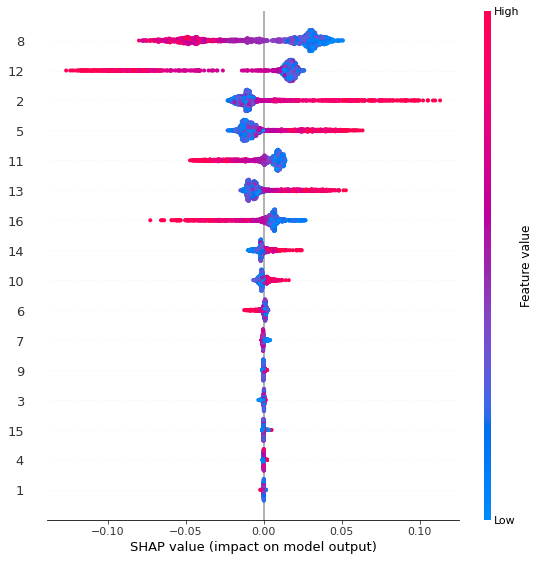

In [13]:
shap.summary_plot(shap_values[1], x_test)

In [14]:
#

In [15]:
feature_names = x_train.columns

paths_list = []
for tree in tqdm(model.estimators_):
	tree = tree.tree_
	
	graph = nx.DiGraph()
	graph, pos = tree_to_networkx(tree, feature_names, graph=graph)
	
	'''# Draw the graph
	labels = nx.get_edge_attributes(graph, 'label')
	nx.draw(graph, pos, with_labels=True, labels=nx.get_node_attributes(graph, 'label'), node_size=2000, font_size=8, node_color='skyblue', edge_color='gray', arrowsize=20)
	nx.draw_networkx_edge_labels(graph, pos, edge_labels={edge: label for edge, label in labels.items()}, font_size=6)

	plt.show()'''
	
	paths = generate_paths(graph)
	paths_list.extend(return_paths(graph, paths))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:01<00:00, 802.43it/s]


In [16]:
paths_list

[[(('12', '<', 5.133), 0.5)],
 [(('12', '<', 5.133), 0.5), (('16', '<', 4.567), 0.54)],
 [(('12', '<', 5.133), 0.5),
  (('16', '<', 4.567), 0.54),
  (('11', '<', 2.677), 0.54)],
 [(('12', '<', 5.133), 0.5),
  (('16', '<', 4.567), 0.54),
  (('11', '>=', 2.677), 0.46)],
 [(('12', '<', 5.133), 0.5), (('16', '>=', 4.567), 0.46)],
 [(('12', '>=', 5.133), 0.5)],
 [(('12', '>=', 5.133), 0.5), (('16', '<', 1.418), 0.29)],
 [(('12', '>=', 5.133), 0.5),
  (('16', '<', 1.418), 0.29),
  (('13', '<', 0.684), 0.47)],
 [(('12', '>=', 5.133), 0.5),
  (('16', '<', 1.418), 0.29),
  (('13', '>=', 0.684), 0.53)],
 [(('12', '>=', 5.133), 0.5), (('16', '>=', 1.418), 0.71)],
 [(('12', '>=', 5.133), 0.5),
  (('16', '>=', 1.418), 0.71),
  (('8', '<', 0.967), 0.21)],
 [(('12', '>=', 5.133), 0.5),
  (('16', '>=', 1.418), 0.71),
  (('8', '>=', 0.967), 0.79)],
 [(('16', '<', 4.567), 0.54)],
 [(('16', '<', 4.567), 0.54), (('11', '<', 2.677), 0.54)],
 [(('16', '<', 4.567), 0.54), (('11', '>=', 2.677), 0.46)],
 [(('1

In [17]:
paths_dictionary = {}
for path in tqdm(paths_list):
	# print(path, len(path))
	
	if len(path) == 1:
		
		if path[0][0] not in list(paths_dictionary.keys()):
			paths_dictionary['_'.join([str(value) for value in path[0][0]])] = []
		
		paths_dictionary['_'.join([str(value) for value in path[0][0]])].append(path[0][1])
	
	else:
		aggregated_path = '&'.join(['_'.join([str(sub_value) for sub_value in value[0]]) for value in path])
		
		if aggregated_path not in list(paths_dictionary.keys()):
			paths_dictionary[aggregated_path] = []
		
		paths_dictionary[aggregated_path].append(path[-1][1])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34704/34704 [00:08<00:00, 4303.68it/s]


In [18]:
paths_dictionary

{'12_<_5.133': [0.48],
 '12_<_5.133&16_<_4.567': [0.54],
 '12_<_5.133&16_<_4.567&11_<_2.677': [0.54],
 '12_<_5.133&16_<_4.567&11_>=_2.677': [0.46],
 '12_<_5.133&16_>=_4.567': [0.46],
 '12_>=_5.133': [0.52],
 '12_>=_5.133&16_<_1.418': [0.29],
 '12_>=_5.133&16_<_1.418&13_<_0.684': [0.47],
 '12_>=_5.133&16_<_1.418&13_>=_0.684': [0.53],
 '12_>=_5.133&16_>=_1.418': [0.71],
 '12_>=_5.133&16_>=_1.418&8_<_0.967': [0.21],
 '12_>=_5.133&16_>=_1.418&8_>=_0.967': [0.79],
 '16_<_4.567': [0.54],
 '16_<_4.567&11_<_2.677': [0.54],
 '16_<_4.567&11_>=_2.677': [0.46],
 '16_>=_4.567': [0.46],
 '11_<_2.677': [0.52],
 '11_>=_2.677': [0.48],
 '16_<_1.418': [0.31],
 '16_<_1.418&13_<_0.684': [0.47],
 '16_<_1.418&13_>=_0.684': [0.53],
 '16_>=_1.418': [0.69],
 '16_>=_1.418&8_<_0.967': [0.21],
 '16_>=_1.418&8_>=_0.967': [0.79],
 '13_<_0.684': [0.47],
 '13_>=_0.684': [0.53],
 '8_<_0.967': [0.27],
 '8_>=_0.967': [0.73],
 '12_<_5.388': [0.54],
 '12_<_5.388&13_<_1.703': [0.54],
 '12_<_5.388&13_<_1.703&12_<_1.569': [0

In [19]:
for key, value in paths_dictionary.items():
	paths_dictionary[key] = np.nanmean(value)

paths_dictionary = sorted(paths_dictionary.items(), key=operator.itemgetter(1), reverse=True)

In [20]:
paths_dictionary

[('12_<_4.906&2_>=_4.068&5_<_0.195', 0.99),
 ('2_>=_4.068&5_<_0.195', 0.99),
 ('5_<_0.195', 0.99),
 ('12_<_5.642', 0.99),
 ('2_>=_3.0&13_>=_2.398&12_<_5.642', 0.99),
 ('13_>=_2.398&12_<_5.642', 0.99),
 ('16_>=_2.929&13_>=_4.236&8_<_12.274', 0.98),
 ('13_>=_4.236&8_<_12.274', 0.98),
 ('8_<_12.274', 0.98),
 ('11_>=_4.006&16_>=_2.121&14_>=_0.078', 0.98),
 ('16_>=_2.121&14_>=_0.078', 0.98),
 ('14_>=_0.078', 0.98),
 ('2_>=_2.066&2_>=_4.088&9_<_2.027', 0.97),
 ('2_>=_4.088&9_<_2.027', 0.97),
 ('9_<_2.027', 0.97),
 ('2_>=_3.281&13_>=_2.248&15_<_0.046', 0.97),
 ('13_>=_2.248&15_<_0.046', 0.97),
 ('15_<_0.046', 0.97),
 ('11_>=_3.343&11_<_3.41&7_>=_0.492', 0.97),
 ('11_<_3.41&7_>=_0.492', 0.97),
 ('7_>=_0.492', 0.97),
 ('8_>=_4.348&11_>=_5.047&3_>=_1.386', 0.97),
 ('11_>=_5.047&3_>=_1.386', 0.97),
 ('3_>=_1.386', 0.97),
 ('14_>=_5.349&8_>=_9.264&10_<_3.249', 0.96),
 ('8_>=_9.264&10_<_3.249', 0.96),
 ('10_<_3.249', 0.96),
 ('2_<_2.585&6_>=_5.295&11_>=_3.49', 0.96),
 ('6_>=_5.295&11_>=_3.49', 0.96

In [21]:
def apply_custom_rules(df, rule_str):
	conditions = rule_str.split('&')
	result = pd.Series([0] * len(df))
	
	for condition in conditions:
		col, op, value = re.split('_([><=]+)_', condition)
		value = float(value)
		
		if op == '>=':
			result |= (df[col] >= value).astype(int)
		elif op == '<':
			result |= (df[col] < value).astype(int)
		else:
			raise ValueError(f'Unsupported operator: {op}')
	
	return result

In [22]:
x_extended_data = deepcopy(x_data)

for index, key in tqdm(enumerate(paths_dictionary[: 1024])):
	key = key[0]
	x_extended_data[f'custom_feature_{index + 1}'] = apply_custom_rules(x_extended_data, key).astype(int)

67it [00:00, 669.40it/s]DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a

134it [00:00, 619.76it/s]DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get 

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

318it [00:00, 595.18it/s]DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get 

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
495it [00:00, 459.73it/s]DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get 

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

665it [00:01, 522.03it/s]DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get 

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

775it [00:01, 536.38it/s]DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get 

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

In [23]:
x_extended_data

,1,2,3,4,5,6,7,8,9,10,...,custom_feature_1015,custom_feature_1016,custom_feature_1017,custom_feature_1018,custom_feature_1019,custom_feature_1020,custom_feature_1021,custom_feature_1022,custom_feature_1023,custom_feature_1024
0,0.646667,2.068667,0.622467,0.894002,2.396024,1.443134,1.502990,4.728787,0.334799,2.462004,...,1,1,1,1,0,0,0,1,1,0
1,0.727514,0.431885,0.693477,1.957176,0.029952,1.676088,0.292154,1.970605,0.339391,1.921717,...,1,1,1,1,1,0,0,0,0,0
2,1.087297,0.580186,0.367525,0.177060,1.250418,1.375619,1.450481,4.951394,0.501132,0.937527,...,1,1,1,1,0,0,0,0,0,0
3,0.984535,0.443221,0.107519,0.176642,2.800435,2.087983,0.447295,1.281822,0.178139,2.348685,...,1,1,0,1,0,1,1,1,1,1
4,0.860216,1.140340,1.000467,0.560525,0.400807,1.793177,1.817460,5.224453,0.106120,0.578770,...,1,1,1,1,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8091,0.544095,0.407010,0.116775,2.571374,3.450447,0.005345,0.135206,0.245552,0.350996,1.094581,...,1,1,0,1,0,0,0,0,0,0
8092,2.196039,1.190144,0.982128,0.884125,1.079320,0.575942,0.011854,4.553926,1.292358,0.030265,...,1,1,1,1,0,0,0,1,1,0
8093,0.192654,2.142140,0.790610,0.326992,1.378456,0.412782,1.980843,0.618667,0.382964,0.620876,...,1,1,1,1,0,0,0,0,0,0
8094,0.990166,1.276872,1.442080,0.687104,0.046010,3.749391,2.775540,9.669624,0.465844,2.511998,...,1,1,1,1,1,0,0,1,1,0


In [24]:
x_extended_data = x_extended_data.T.drop_duplicates().T

In [25]:
x_extended_data

,1,2,3,4,5,6,7,8,9,10,...,custom_feature_1015,custom_feature_1016,custom_feature_1017,custom_feature_1018,custom_feature_1019,custom_feature_1020,custom_feature_1021,custom_feature_1022,custom_feature_1023,custom_feature_1024
0,0.646667,2.068667,0.622467,0.894002,2.396024,1.443134,1.502990,4.728787,0.334799,2.462004,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.727514,0.431885,0.693477,1.957176,0.029952,1.676088,0.292154,1.970605,0.339391,1.921717,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.087297,0.580186,0.367525,0.177060,1.250418,1.375619,1.450481,4.951394,0.501132,0.937527,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.984535,0.443221,0.107519,0.176642,2.800435,2.087983,0.447295,1.281822,0.178139,2.348685,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
4,0.860216,1.140340,1.000467,0.560525,0.400807,1.793177,1.817460,5.224453,0.106120,0.578770,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8091,0.544095,0.407010,0.116775,2.571374,3.450447,0.005345,0.135206,0.245552,0.350996,1.094581,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8092,2.196039,1.190144,0.982128,0.884125,1.079320,0.575942,0.011854,4.553926,1.292358,0.030265,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
8093,0.192654,2.142140,0.790610,0.326992,1.378456,0.412782,1.980843,0.618667,0.382964,0.620876,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8094,0.990166,1.276872,1.442080,0.687104,0.046010,3.749391,2.775540,9.669624,0.465844,2.511998,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0


In [26]:
x_extended_train = x_extended_data.iloc[x_train.index]
x_extended_test = x_extended_data.iloc[x_test.index]

In [27]:
model.fit(x_extended_train, y_train)
print(balanced_accuracy_score(y_test, model.predict(x_extended_test)))

0.6615663047054952


In [28]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_extended_test)

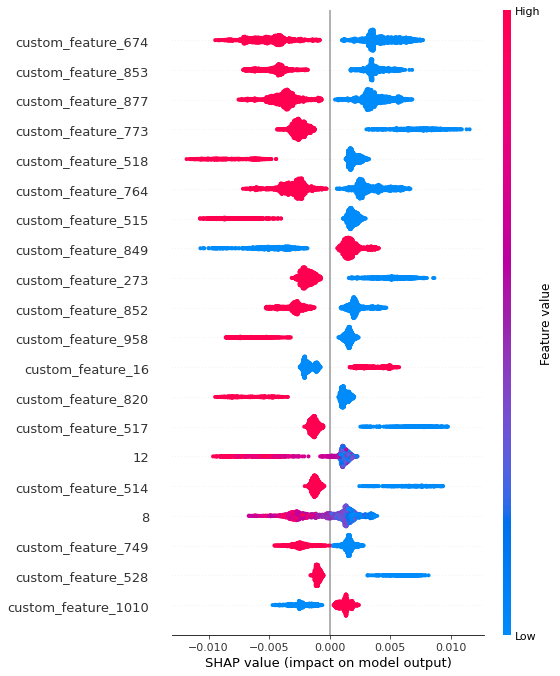

In [29]:
shap.summary_plot(shap_values[1], x_extended_test)